In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from sklearn.datasets import fetch_20newsgroups
dataset = fetch_20newsgroups(subset="all", remove=('headers', 'footers', 'quotes'),
            shuffle=True, return_X_y=True)

In [3]:
dataset[1][0]

10

In [4]:
dataset[0][0]

"\n\nI am sure some bashers of Pens fans are pretty confused about the lack\nof any kind of posts about the recent Pens massacre of the Devils. Actually,\nI am  bit puzzled too and a bit relieved. However, I am going to put an end\nto non-PIttsburghers' relief with a bit of praise for the Pens. Man, they\nare killing those Devils worse than I thought. Jagr just showed you why\nhe is much better than his regular season stats. He is also a lot\nfo fun to watch in the playoffs. Bowman should let JAgr have a lot of\nfun in the next couple of games since the Pens are going to beat the pulp out of Jersey anyway. I was very disappointed not to see the Islanders lose the final\nregular season game.          PENS RULE!!!\n\n"

In [5]:
g = dataset[0][0].split("\n")
g = list(filter(lambda a: a != '', g))
g

['I am sure some bashers of Pens fans are pretty confused about the lack',
 'of any kind of posts about the recent Pens massacre of the Devils. Actually,',
 'I am  bit puzzled too and a bit relieved. However, I am going to put an end',
 "to non-PIttsburghers' relief with a bit of praise for the Pens. Man, they",
 'are killing those Devils worse than I thought. Jagr just showed you why',
 'he is much better than his regular season stats. He is also a lot',
 'fo fun to watch in the playoffs. Bowman should let JAgr have a lot of',
 'fun in the next couple of games since the Pens are going to beat the pulp out of Jersey anyway. I was very disappointed not to see the Islanders lose the final',
 'regular season game.          PENS RULE!!!']

In [6]:
len(dataset[0]), len(dataset[1])

(18846, 18846)

In [7]:
def split_data(data, idx): 
    """Split data for easy visualization. NOT FOR TRAINING."""
    x = data[idx].split("\n")
    x = list(filter(lambda a: a != '', x))
    return x

In [8]:
split_data(dataset[0], 20)

[': ',
 ': I am considering buying a 1993 Chevy or GMC 4x4 full-size pickup with',
 ': the extended cab.  Any opinions about these vehicles?  Have there been',
 ': any significant problems?',
 ': ',
 ': -- ',
 ': Dick Grady           Salem, NH,  USA            grady@world.std.com',
 ': So many newsgroups, so little time!',
 'I bought a brand new 1992 Chevrolet K2500 HD 4x4 extended cab last',
 'May.  It has had many, many problems.  See my earler post that describes',
 'the situation.  I went to BBB arbitration, and they ruled that Chevrolet',
 'must buy it back from me.  If you do get one, stay away from the 5 speed',
 'manual with the deep low first gear.  They have put three of them in my',
 'truck so far.  After about 1,500 miles, overdrive either starts',
 'rattling or hissing loudly.  There is no way to fix them.  Chevrolet ',
 'says that the noise is "a characteristic of the transmission."',
 'Also, if you are planning to use your truck to tow, the',
 'gear ratios in that tranny

# Initial training and see how it goes. 

In [9]:
from fastai.text.all import *

In [167]:
train_xs = [g.lower() for g in dataset[0]]  # Make all lower case.
y = dataset[1]

In [11]:
assert len(train_xs) == 18846
assert len(y) == 18846

In [12]:
import pandas as pd
df = pd.DataFrame([train_xs, y]).T
df.columns = ["text", "category"]

In [13]:
df.head(2)

,text,category
0,"\n\ni am sure some bashers of pens fans are pretty confused about the lack\nof any kind of posts about the recent pens massacre of the devils. actually,\ni am bit puzzled too and a bit relieved. however, i am going to put an end\nto non-pittsburghers' relief with a bit of praise for the pens. man, they\nare killing those devils worse than i thought. jagr just showed you why\nhe is much better than his regular season stats. he is also a lot\nfo fun to watch in the playoffs. bowman should let jagr have a lot of\nfun in the next couple of games since the pens are going to beat the pulp out o...",10
1,my brother is in the market for a high-performance video card that supports\nvesa local bus with 1-2mb ram. does anyone have suggestions/ideas on:\n\n - diamond stealth pro local bus\n\n - orchid farenheit 1280\n\n - ati graphics ultra pro\n\n - any other high-performance vlb card\n\n\nplease post or email. thank you!\n\n - matt\n,3


**Note for bottom**: Your `ColReader()` should **always** be `text` for the text files (that is, whenever you use `TextBlock.from_df("actual_col_name", ...)` in the `blocks`), it has nothing to do with the column names, but it's a pandas Series "col name" that is done internally. This is the part which confuses in the documentation. 

In [14]:
seq_len = 36  # Sequence length, useful for data and for LSTM/RNN. 

dls = DataBlock(
    blocks=(TextBlock.from_df("text", seq_len=seq_len, tok=SpacyTokenizer("en")),
            CategoryBlock),
    get_x=ColReader("text"), get_y=ColReader("category"),
    splitter=RandomSplitter(0.1)
).dataloaders(df, bs=32, num_workers=0, seq_len=seq_len)

/anaconda/envs/fastai/lib/python3.8/site-packages/numpy/core/_asarray.py:102: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order)


In [15]:
dls.show_batch(max_n=2)

,text,category
0,"xxbos try this one on for size . i 'd rather not post her name , but if you \n email me , i 'll tell you who she is . enjoy ! \n\n begin 640 xxunk \n xxunk # ! ! 0 ( , ! xxunk ! +8 [ p ( xxunk \n xxunk # xxunk \ # xxunk ] xxunk [ # xxunk \ i8 \n xxunk - xxunk # ; xxunk : xxunk xxrep 3 ( xxunk \n m \ < / xxunk \ _ xxunk < xxunk / % \ _ / e \ xxunk ? # xxunk \n m3 = xxunk & / $ _ & , xxunk / + xxunk ( xxrep 3 g % r. / [ ] xxunk \ \ xxunk \ \n xxunk / , xxunk = xxunk # xxunk > xxunk & > / , \n xxunk \ xxunk \n",2
1,"xxbos here 's a listing that i came accross a while ago . this question seems to \n come up often enough that i figured this would be of interest . note that \n the server "" x appeal "" for dos is available in demo form on the internet via \n anonymous ftp . this is one way of quickly checking out the feasability of \n using your system as an x server . enjoy ! \n\n - pete \n\n▁ xxrep 31 - begin enclosure xxrep 28 - \n from : mccoy@gothamcity.jsc.nasa.gov ( daniel j. mccoy ) \n newsgroups : comp.windows.x , news.answers \n subject : x servers for dos , microsoft windows , os / 2 , macs , amigas , atari \n reply - to : mccoy@gothamcity.jsc.nasa.gov ( daniel j. mccoy ) \n organization : i - net inc . \n summary : this is a guide",5


In [16]:
L(dls.vocab[0])  # L object will shorten the output. 

(#41464) ['xxunk','xxpad','xxbos','xxeos','xxfld','xxrep','xxwrep','xxup','xxmaj','\n'...]

In [17]:
dls.vocab[1]

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]

In [18]:
learn = text_classifier_learner(dls, AWD_LSTM, metrics=[accuracy, Perplexity()],
                wd=0.1, drop_mult=0.3, pretrained=True).to_fp16()

/anaconda/envs/fastai/lib/python3.8/site-packages/fastai/callback/schedule.py:269: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "ro" (-> color='r'). The keyword argument will take precedence.
  ax.plot(val, idx, 'ro', label=nm, c=color)


SuggestedLRs(valley=0.0030199517495930195)

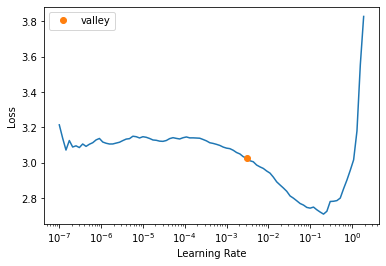

In [19]:
learn.lr_find()

In [20]:
learn.fit_one_cycle(2, 3e-2)

epoch,train_loss,valid_loss,accuracy,perplexity,time
0,1.990998,2.000274,0.423567,7.391082,05:40
1,1.776122,1.646409,0.511677,5.188315,05:44


Try again with `num_workers=os.cpu_count()` if possible to speed up things (plus a stronger GPU if possible). Only change back to `num_workers=0` if you encountered CUDA error (whatever error it is, usually it's this problem but it could be a variety of CUDA errors). 

Next we want to know whether removing those that are less than 35 lines (our threshold) will improve the score or not. 

In [25]:
def split_data(data, idx=None): 
    """Split data for easy visualization. NOT FOR TRAINING."""
    if idx is not None: x = data[idx].split("\n")
    else: x = data.split("\n")
    x = list(filter(lambda a: a != '', x))
    return x

In [27]:
for i in train_xs[:5]: print(len(split_data(i)))

9
8
38
12
11


In [34]:
to_keep = []
threshold = 35

for k, x in enumerate(train_xs): 
    sentence_len = len(split_data(x))
    if sentence_len >= threshold: to_keep.append(k)
    else: pass

to_keep = np.array(to_keep)
to_keep

array([    2,    12,    18, ..., 18820, 18832, 18838])

In [35]:
len(to_keep), to_keep.max(), to_keep.min(), len(np.unique(to_keep))

(1862, 18838, 2, 1862)

In [39]:
new_xs = np.array(train_xs)[to_keep]
new_y = np.array(y)[to_keep]

In [40]:
assert len(new_xs) == len(to_keep)
assert len(new_y) == len(to_keep)

In [47]:
def numpy_to_pd_to_dls(train_xs, y, seq_len=seq_len):
    df = pd.DataFrame([train_xs, y]).T
    df.columns = ["text", "category"]

    dls = DataBlock(
        blocks=(TextBlock.from_df("text", seq_len=seq_len, tok=SpacyTokenizer("en")),
                CategoryBlock),
        get_x=ColReader("text"), get_y=ColReader("category"),
        splitter=RandomSplitter(0.1)
    ).dataloaders(df, bs=32, num_workers=0, seq_len=seq_len)

    return dls

In [43]:
# Clear some memory. 
del learn, dls
import gc
gc.collect()
torch.cuda.empty_cache()

16093

In [48]:
dls = numpy_to_pd_to_dls(new_xs, new_y)

/anaconda/envs/fastai/lib/python3.8/site-packages/numpy/core/_asarray.py:102: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order)


In [49]:
dls.show_batch(max_n=2)

,text,category
0,"xxbos try this one on for size . i 'd rather not post her name , but if you \n email me , i 'll tell you who she is . enjoy ! \n\n begin 640 xxunk \n xxunk # ! ! 0 ( , ! xxunk ! +8 [ p ( xxunk \n xxunk # xxunk \ # xxunk ] xxunk [ # xxunk \ i8 \n xxunk - xxunk # ; xxunk : xxunk xxrep 3 ( xxunk \n m \ < / xxunk \ _ xxunk < xxunk / % \ _ / e \ xxunk ? # xxunk \n m3 = xxunk & / $ _ & , xxunk / + xxunk ( xxrep 3 g % r. / [ ] xxunk \ \ xxunk \ \n xxunk / , xxunk = xxunk # xxunk > xxunk & > / , \n xxunk \ xxunk \n",2
1,"xxbos due to the resolution and size it is in 14 parts . \n\n this is a uuencoded bitmap . xxunk 256 colors . \n the picture is a xxunk xxunk on a desert with blue sky background . \n the size is just right for centered wallpaper on a 1024x768 display \n because it leaves a border at the bottom just big enough for icons \n to fit in without being on top of the picture . xxunk image \n quality and resolution - i have not seen much better . \n\n for those of you who have n't worked with xxunk image files , here \n is how to put it back together . \n\t 1 . save the 14 parts to 14 individual files \n\t 2 . use a text editor to remove the header and xxunk \n\t▁ in each file . \n\t 3 . xxunk all",2


/anaconda/envs/fastai/lib/python3.8/site-packages/fastai/callback/schedule.py:269: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "ro" (-> color='r'). The keyword argument will take precedence.
  ax.plot(val, idx, 'ro', label=nm, c=color)


SuggestedLRs(valley=0.12022644281387329)

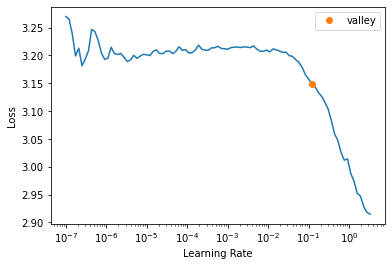

In [50]:
learn = text_classifier_learner(dls, AWD_LSTM, metrics=[accuracy, Perplexity()],
                wd=0.1, drop_mult=0.3, pretrained=True).to_fp16()
learn.lr_find()

In [51]:
learn.fit_one_cycle(2, 3e-2)

epoch,train_loss,valid_loss,accuracy,perplexity,time
0,2.887219,2.606261,0.225806,13.548306,02:38
1,2.562971,2.460787,0.268817,11.714030,02:39


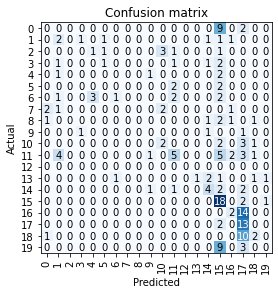

In [52]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

In [117]:
interp.plot_top_losses(2)

,input,target,predicted,probability,loss
0,"xxbos another f2 rider had similiar problems , and this is the mail i sent him , \n hope this helps resolve you problem ! \n\n at \n\n\n good point , did not catch this in the original post . the only other things \n which come to mind , since this is a gravity feed fuel system , is this . \n the fuel petcock valve is vacuum controlled from the # 1 xxunk . let \n suppose there is a small hole or bad seal either in the hose itself or the \n vacuum valve in the fuel petcock . when it is cold , the hole is open enough \n to open the valve just enough to allow gas to the carbs with the choke on , \n since the choke creates more low pressure in the carbs when on to draw gas , \n and as",8,15,0.11897174268960953,4.11470890045166
1,"xxbos % \n % request for opinions : \t\n % \n % which is better - a one - piece xxunk or a two - piece xxunk ? \n % \n\n\n like most everyone else , i ended up getting two different sizes for \n the top and bottom . my top is a xxunk and the bottom is a xxunk . for the \n bottom , the waist is far too large , but the thighs fit just right ( the \n 46 had a better waist , but cut off the circulation in my legs , i have \n large , xxunk thighs , and no , i did n't use the xxunk to get \n them :-) . the jacket fits me ok in the chest , slightly snug at the \n waist , and too small in the arms . i ca n't imagine finding a",8,18,0.11166947335004807,4.036938667297363


In [56]:
len(dls.vocab[0])

31032

In [67]:
import re
test_2 = re.sub(r'[\t*]', '', train_xs[2])
test_2 = re.sub(r'[\n]', ' ', test_2)
test_2

'    finally you said what you dream about. mediterranean???? that was new.... the area will be "greater" after some years, like your "holocaust" numbers......      is\'t july in usa now????? here in sweden it\'s april and still cold. or have you changed your calendar???                    nothing of the mentioned is true, but let say it\'s true.  shall the azeri women and children going to pay the price with      being raped, killed and tortured by the armenians??????????  have you hearded something called: "geneva convention"??????? you facist!!!!!    ohhh i forgot, this is how armenians fight, nobody has forgot you killings, rapings and torture against the kurds and turks once upon a time!                  ohhhh so swedish redcross workers do lie they too? what ever you say "regional killer", if you don\'t like the person then shoot him that\'s your policy.....l   i i i confused?????i i         search turkish planes? you don\'t know what you are talking about.i         turkey\'s gov

In [104]:
test_3 = re.sub("[:<>]", "", train_xs[2463])
test_3 = re.sub("\n", ' ', test_3)
test_3 = test_3.replace("\\", "")
# test_3 = re.sub(r'\\', "", test_3)
# test_3 = re.sub("\w+\'", "+'", test_3)
test_3

'victor johnson, on the thu, 22 apr 1993 000110 gmt wibbled    }honda  a "v" designates a v engine street bike. "vf" for v-4, "vt" for v-twin.      so how about my honda hawk (nt 650)? it\'s a twin, but not called a vt.   --      that\'s because they took the old vt 500 engine and stepped on it to make    the plant for the hawk - "new twin".  or does that only fly for microsoft    nt (new technology)?     i\'ve been at this too long today ...     cheers,    victor "dances with hawks" johnson    ----------------------------------   also the bmw stuff.  k100rs.  k = kraut, rs = really slow,  100, i suppose that\'s how much you have to spend each week to keep the damn thing on the road. --  nick (the pissed off with his bike again biker)   dod 1069   concise oxford  m\'lud.'

In [99]:
text = "We\'ve ... here\'s why ... That\'s how ... it\'s"
text = text.replace("\\", "")
text

"We've ... here's why ... That's how ... it's"

In [110]:
p = re.compile('[\n/:()<>|?*]|(\\\)')
p.sub(" ", train_xs[2463])

'victor johnson, on the thu, 22 apr 1993 00 01 10 gmt wibbled       }honda   a "v" designates a v engine street bike. "vf" for v-4, "vt" for v-twin.          so how about my honda hawk  nt 650   it\'s a twin, but not called a vt.     --       that\'s because they took the old vt 500 engine and stepped on it to make     the plant for the hawk -  "new twin".  or does that only fly for microsoft     nt  new technology        i\'ve been at this too long today ...      cheers,     victor "dances with hawks" johnson     ----------------------------------   also the bmw stuff.  k100rs.  k = kraut, rs = really slow,  100, i suppose that\'s how much you have to spend each week to keep the damn thing on the road. --  nick  the pissed off with his bike again biker    dod 1069   concise oxford  m\'lud.'

Failure to replace `\` with what we wanted. 

In [123]:
def substitute(text): 
    text = re.sub("[:<>\t*]", "", text)
    text = re.sub("\n", " ", text)
    # this is not working for unknown reason.
    ### text = text.replace("\\", "")  
    # So we use this instead. 
    text = text.split("\'")
    text = "'".join(text)
    return text

Let's do retraining. 

In [124]:
new_xs_subbed = np.array([substitute(x) for x in new_xs])
new_xs_subbed[2]

' the supreme court seems to disagree with you -- they have stated that "the people" is a term of art refering to an individual right, and have explicitly mentioned the second amendment as an example.  i quote    "... \'the people\' seems to have been a term of art employed in   select parts of the constitution.  the preamble declares that the   constitution is ordained, and established by \'the people of the   the u.s.\'  the second amendment protects the right of the people   to keep and bear arms ...." - supreme court of the u.s.,  u.s. v. uerdugo-uriquidez (1990).  furthermore, in the miller decision, they only permitted prosecution for possession of a sawed-off shotgun because the defense had not presented testimony and they therefore accepted the argument of the government that such weapons have no military value -- they held that the amendment protected the individual right to possess military weapons. unfortunately, no second amendment case has successfully gotten to the court 

In [125]:
# Clear some memory. 
del learn, dls
import gc
gc.collect()
torch.cuda.empty_cache()

In [126]:
dls = numpy_to_pd_to_dls(new_xs_subbed, new_y)
dls.show_batch(max_n=2)

/anaconda/envs/fastai/lib/python3.8/site-packages/numpy/core/_asarray.py:102: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order)


,text,category
0,"xxbos try this one on for size . i 'd rather not post her name , but if you email me , i 'll tell you who she is . enjoy ! begin 640 xxunk xxunk # ! ! 0 ( , ! xxunk ! +8 [ p ( xxunk xxunk # xxunk \ # xxunk ] xxunk [ # xxunk \ xxunk xxunk - xxunk # ; xxunk xxrep 3 ( xxunk m \ / xxunk \ _ xxunk / % \ _ / e \ xxunk ? # xxunk m3 = xxunk & / $ _ & , xxunk / + xxunk ( xxrep 3 g % r. / [ ] xxunk \ \ xxunk \ xxunk / , x6 = xxunk # xxunk & / , xxunk \ xxunk xxunk \ xxunk xxunk \ xxunk / xxunk / ' . xxunk / xxunk \ % xxunk /",2
1,"xxbos due to the resolution and size it is in 14 parts . this is a uuencoded bitmap . xxunk 256 colors . the picture is a xxunk xxunk on a desert with blue sky background . the size is just right for centered wallpaper on a 1024x768 display because it leaves a border at the bottom just big enough for icons to fit in without being on top of the picture . xxunk image quality and resolution - i have not seen much better . for those of you who have n't worked with xxunk image files , here is how to put it back together . 1 . save the 14 parts to 14 individual files 2 . use a text editor to remove the header and xxunk in each file . 3 . xxunk all the parts into a single file 4 . uudecode the file there",2


In [127]:
def get_learner(dls): 
    return text_classifier_learner(dls, AWD_LSTM, metrics=[accuracy, Perplexity()],
                wd=0.1, drop_mult=0.3, pretrained=True).to_fp16()

/anaconda/envs/fastai/lib/python3.8/site-packages/fastai/callback/schedule.py:269: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "ro" (-> color='r'). The keyword argument will take precedence.
  ax.plot(val, idx, 'ro', label=nm, c=color)


SuggestedLRs(valley=0.04786301031708717)

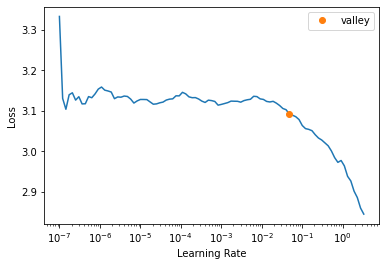

In [128]:
learn = get_learner(dls)
learn.lr_find()

In [129]:
learn.fit_one_cycle(2, 3e-2)

epoch,train_loss,valid_loss,accuracy,perplexity,time
0,2.835243,2.528243,0.301075,12.531464,02:19
1,2.533997,2.341905,0.327957,10.401032,02:20


Previously we have about 0.26 accuracy. Now: 
- without replacing `\` we get 0.36.
- with replacing `\` we get 0.32.

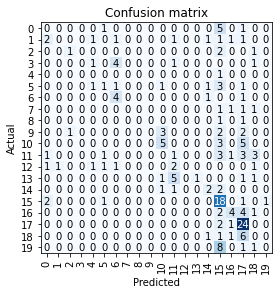

In [168]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

One notices there are some data with **a lot** of `xxunk` undefined sequences. They do not make up a good dataset, so we'll have to delete them. 

Do remember, we're still using our subset here. The steps will be the same to deal with the full dataset. 

In [187]:
choice = np.zeros((len(dls.train_ds), )).astype(np.float32)
for k, (our_x, _) in enumerate(dls.train_ds): 
    choice[k] = int((our_x == 0).sum()) / len(our_x)

In [204]:
df_new_sub = pd.DataFrame([new_xs_subbed, new_y]).T
df_new_sub.columns = df.columns

In [250]:
def itos(vocab, word, join=False, ignore_pad=False): 
    import fastai
    if not isinstance(vocab, np.ndarray): vocab = np.array(vocab)
    if type(word) in [tuple, fastai.text.data.TensorText]: 
        word = np.array(word)
    word = vocab[word]
    if ignore_pad: word = word[word != "xxpad"]
    if join: return " ".join(word)

    return word

In [297]:
def stoi(vocab, word): 
    import fastcore
    if isinstance(word, fastcore.foundation.L): raise NotImplementedError
    if not isinstance(vocab, np.ndarray): vocab = np.array(vocab)
    if type(word) in [list, tuple, np.ndarray]: 
        m = np.zeros((len(word), )).astype(np.uint8)
        for k in range(len(word)):
            try: m[k] = np.where(vocab == word[k])[0].item()
            except ValueError: m[k] = 0
        return m
    try: return np.where(vocab == word)[0].item()
    except ValueError: raise ValueError("word not in vocab")

In [304]:
df_new_toked = tokenize_df(df_new_sub, "text", n_workers=os.cpu_count(),
                tok=dls.tok)[0]

/anaconda/envs/fastai/lib/python3.8/site-packages/numpy/core/_asarray.py:102: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order)


The above function returns two objects: we took the zeroth object which is a pandas dataframe, while the first object is a counter counting how many of each vocab are present inside the data. Note that this tokenization doesn't have tokenize to "xxunk" which is what we want, and shall we deal with that now. 

In [311]:
from tqdm.auto import tqdm

In [317]:
choice_list = []
def make_choice(k, data, threshold=0.3):
    g = stoi(dls.vocab[0], " ".join(data))
    # choice[k] = (g == 0).sum() / len(g)
    if (g == 0).sum() / len(g) > threshold: choice_list.append(k)

In [318]:
choice = np.zeros((len(df_new_toked), )).astype(np.float32)
loop_over = df_new_toked["text"].to_numpy()

# parallelize
import joblib

_ = joblib.Parallel(n_jobs=os.cpu_count(), prefer="threads")(
    joblib.delayed(make_choice)(k, data) 
    for k, data in enumerate(tqdm(loop_over))
)

# for k, data in enumerate(tqdm(loop_over)): 
#     g = stoi(dls.vocab[0], " ".join(data))
#     choice[k] = (g == 0).sum() / len(g)

  0%|          | 0/1862 [00:00<?, ?it/s]

In [320]:
np.save("temp_choice_subset", np.array(choice_list))

I would like to see whether I can improve the `stoi` function or not, because this function is just too slow to do stuffs. 

# Experimentation phase
- Convert vocab to python dictionary
- Use dictionary to access values. 

In [325]:
yourList = dls.vocab[0]
result = {key: index for index, key in enumerate(yourList)}
result

{'xxunk': 0,
 'xxpad': 1,
 'xxbos': 2,
 'xxeos': 3,
 'xxfld': 4,
 'xxrep': 5,
 'xxwrep': 6,
 'xxup': 7,
 'xxmaj': 8,
 ',': 9,
 'the': 10,
 '.': 11,
 'of': 12,
 'to': 13,
 'and': 14,
 '-': 15,
 'a': 16,
 '/': 17,
 'in': 18,
 ')': 19,
 '"': 20,
 'is': 21,
 '(': 22,
 'that': 23,
 'i': 24,
 '#': 25,
 'it': 26,
 'for': 27,
 '\\': 28,
 'you': 29,
 "'": 30,
 '=': 31,
 'on': 32,
 'this': 33,
 'are': 34,
 'be': 35,
 'not': 36,
 'with': 37,
 '?': 38,
 'as': 39,
 "'s": 40,
 'have': 41,
 '3': 42,
 ';': 43,
 'or': 44,
 'was': 45,
 'by': 46,
 'they': 47,
 'from': 48,
 '1': 49,
 "n't": 50,
 'but': 51,
 'do': 52,
 'if': 53,
 'at': 54,
 'we': 55,
 ']': 56,
 '0': 57,
 'x': 58,
 'an': 59,
 '$': 60,
 'can': 61,
 'he': 62,
 'will': 63,
 'all': 64,
 'what': 65,
 'there': 66,
 'one': 67,
 '2': 68,
 '_': 69,
 '!': 70,
 '[': 71,
 '…': 72,
 'were': 73,
 'would': 74,
 'your': 75,
 'has': 76,
 'about': 77,
 'which': 78,
 'no': 79,
 'my': 80,
 'who': 81,
 'their': 82,
 'so': 83,
 '4': 84,
 'some': 85,
 'people': 8

In [326]:
%timeit result["xxup"]

46.9 ns ± 0.723 ns per loop (mean ± std. dev. of 7 runs, 10000000 loops each)
